# CNN + CapsGNN for GI Image Classification

This notebook implements a hybrid model:
- **CNN backbone** for local feature extraction
- **Primary Capsules** for part-whole representation
- **Graph Neural Network (CapsGNN)** over capsule nodes for relational reasoning

In [ ]:
!pip install torch torchvision torchaudio
!pip install numpy tqdm scikit-learn matplotlib

In [1]:
import os
import random
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms, models
from torchvision.models import ResNet18_Weights
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt

# ---------------------------
# Reproducibility + Device
# ---------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# ---------------------------
# Paths + Hyperparameters
# ---------------------------
# Set this to your Kvasir dataset root containing class folders
DATA_DIR = r"/kaggle/input/datasets/sameer512100/kvasir-minor-project/kvasir-dataset-v2"

IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 15
LR = 1e-4
WEIGHT_DECAY = 1e-5
K_NEIGHBORS = 8
MAX_CAPS_NODES = 128
EXPECTED_NUM_CLASSES = 8
EARLY_STOPPING_PATIENCE = 7
MIN_DELTA = 1e-4
NUM_WORKERS = min(4, os.cpu_count() or 0)

CHECKPOINT_DIR = os.path.join(os.getcwd(), 'checkpoints')
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
print('Checkpoint dir:', CHECKPOINT_DIR)

if not os.path.isdir(DATA_DIR):
    raise FileNotFoundError(f"DATA_DIR not found: {DATA_DIR}. Please update DATA_DIR in this cell.")

Device: cuda
Checkpoint dir: /kaggle/working/checkpoints


In [2]:
# ---------------------------
# Dataset + DataLoaders (with augmentation)
# ---------------------------
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.10, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

eval_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

base_dataset = datasets.ImageFolder(DATA_DIR)
class_names = base_dataset.classes
num_classes = len(class_names)

if num_classes != EXPECTED_NUM_CLASSES:
    raise ValueError(f"Expected {EXPECTED_NUM_CLASSES} classes, but found {num_classes}: {class_names}")

n_samples = len(base_dataset)
train_size = int(0.70 * n_samples)
val_size = int(0.15 * n_samples)
test_size = n_samples - train_size - val_size

generator = torch.Generator().manual_seed(SEED)
indices = torch.randperm(n_samples, generator=generator).tolist()

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

train_base = datasets.ImageFolder(DATA_DIR, transform=train_transform)
val_base = datasets.ImageFolder(DATA_DIR, transform=eval_transform)
test_base = datasets.ImageFolder(DATA_DIR, transform=eval_transform)

train_dataset = Subset(train_base, train_indices)
val_dataset = Subset(val_base, val_indices)
test_dataset = Subset(test_base, test_indices)

pin_mem = torch.cuda.is_available()
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=pin_mem)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=pin_mem)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=pin_mem)

print('Classes:', class_names)
print(f'Train/Val/Test: {len(train_dataset)}/{len(val_dataset)}/{len(test_dataset)}')

Classes: ['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis', 'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps', 'ulcerative-colitis']
Train/Val/Test: 5600/1200/1200


In [3]:
# ---------------------------
# Models: CNN baseline, CNN+Caps, CNN+CapsGNN
# ---------------------------
def squash(x, dim=-1, eps=1e-8):
    norm_sq = (x ** 2).sum(dim=dim, keepdim=True)
    scale = norm_sq / (1.0 + norm_sq)
    norm = torch.sqrt(norm_sq + eps)
    return scale * (x / norm)


class PrimaryCapsules(nn.Module):
    def __init__(self, in_channels, num_capsules=8, caps_dim=16, kernel_size=1, stride=1):
        super().__init__()
        self.num_capsules = num_capsules
        self.caps_dim = caps_dim
        self.conv = nn.Conv2d(in_channels, num_capsules * caps_dim, kernel_size=kernel_size, stride=stride)

    def forward(self, x):
        out = self.conv(x)
        b, _, h, w = out.shape
        out = out.view(b, self.num_capsules, self.caps_dim, h, w)
        out = out.permute(0, 3, 4, 1, 2).contiguous()
        out = out.view(b, h * w * self.num_capsules, self.caps_dim)
        return squash(out)


def reduce_capsule_nodes(capsules, max_nodes=128):
    # capsules: [B, N, D]
    b, n, d = capsules.shape
    if n <= max_nodes:
        return capsules
    pooled = F.adaptive_avg_pool1d(capsules.transpose(1, 2), max_nodes).transpose(1, 2)
    return pooled


def build_knn_graph(capsules, k=8):
    """
    capsules: [B, N, D]
    returns adjacency: [B, N, N] (row-normalized)
    """
    b, n, _ = capsules.shape
    x = F.normalize(capsules, p=2, dim=-1)
    sim = torch.bmm(x, x.transpose(1, 2))

    k_eff = min(k, n)
    topk_vals, topk_idx = torch.topk(sim, k=k_eff, dim=-1)

    adj = torch.zeros_like(sim)
    adj.scatter_(dim=-1, index=topk_idx, src=F.relu(topk_vals))

    eye = torch.eye(n, device=capsules.device).unsqueeze(0).expand(b, -1, -1)
    adj = adj + eye
    row_sum = adj.sum(dim=-1, keepdim=True).clamp_min(1e-8)
    return adj / row_sum


class GraphConv(nn.Module):
    def __init__(self, in_dim, out_dim, dropout=0.1):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim)
        self.dropout = nn.Dropout(dropout)
        self.bn = nn.BatchNorm1d(out_dim)

    def forward(self, x, adj):
        h = self.linear(x)
        h = torch.bmm(adj, h)

        b, n, d = h.shape
        h = self.bn(h.reshape(b * n, d)).reshape(b, n, d)
        h = F.relu(h)
        return self.dropout(h)


class ResNet18Backbone(nn.Module):
    def __init__(self, pretrained=True, freeze_early_layers=True):
        super().__init__()
        weights = ResNet18_Weights.IMAGENET1K_V1 if pretrained else None
        base = models.resnet18(weights=weights)
        self.features = nn.Sequential(*list(base.children())[:-2])  # [B, 512, 7, 7]

        if freeze_early_layers:
            for idx, module in enumerate(self.features):
                if idx < 6:  # freeze up to layer2
                    for param in module.parameters():
                        param.requires_grad = False

    def forward(self, x):
        return self.features(x)


class CNNBaseline(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = ResNet18Backbone(pretrained=True, freeze_early_layers=True)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        feat = self.backbone(x)
        emb = self.pool(feat).flatten(1)
        return self.classifier(emb)


class CNNCapsClassifier(nn.Module):
    def __init__(self, num_classes, max_caps_nodes=128):
        super().__init__()
        self.max_caps_nodes = max_caps_nodes
        self.backbone = ResNet18Backbone(pretrained=True, freeze_early_layers=True)
        self.primary_caps = PrimaryCapsules(in_channels=512, num_capsules=8, caps_dim=16, kernel_size=1, stride=1)
        self.classifier = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        feat = self.backbone(x)
        caps = self.primary_caps(feat)
        caps = reduce_capsule_nodes(caps, max_nodes=self.max_caps_nodes)
        emb = caps.mean(dim=1)
        return self.classifier(emb)


class CNNCapsGNN(nn.Module):
    def __init__(self, num_classes, k_neighbors=8, max_caps_nodes=128):
        super().__init__()
        self.k_neighbors = k_neighbors
        self.max_caps_nodes = max_caps_nodes

        self.backbone = ResNet18Backbone(pretrained=True, freeze_early_layers=True)
        self.primary_caps = PrimaryCapsules(in_channels=512, num_capsules=8, caps_dim=16, kernel_size=1, stride=1)

        self.gnn1 = GraphConv(16, 32, dropout=0.15)
        self.gnn2 = GraphConv(32, 32, dropout=0.15)

        self.classifier = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        feat = self.backbone(x)
        caps = self.primary_caps(feat)
        caps = reduce_capsule_nodes(caps, max_nodes=self.max_caps_nodes)

        adj = build_knn_graph(caps, k=self.k_neighbors)
        h = self.gnn1(caps, adj)
        h = self.gnn2(h, adj)

        graph_emb = h.mean(dim=1)
        return self.classifier(graph_emb)


model_factories = {
    'CNN only': lambda: CNNBaseline(num_classes=num_classes),
    'CNN + Capsules': lambda: CNNCapsClassifier(num_classes=num_classes, max_caps_nodes=MAX_CAPS_NODES),
    'CNN + CapsGNN': lambda: CNNCapsGNN(num_classes=num_classes, k_neighbors=K_NEIGHBORS, max_caps_nodes=MAX_CAPS_NODES),
}

print('Ablation models:', list(model_factories.keys()))

Ablation models: ['CNN only', 'CNN + Capsules', 'CNN + CapsGNN']


In [ ]:
# ---------------------------
# Train / Eval utilities + Ablation study
# ---------------------------
import json
import zipfile

def backup_checkpoints(checkpoint_dir, backup_zip_path):
    if not os.path.isdir(checkpoint_dir):
        return
    with zipfile.ZipFile(backup_zip_path, mode='w', compression=zipfile.ZIP_DEFLATED) as zf:
        for root, _, files in os.walk(checkpoint_dir):
            for fname in files:
                if fname.endswith('.pth') or fname.endswith('.json'):
                    fpath = os.path.join(root, fname)
                    arcname = os.path.relpath(fpath, checkpoint_dir)
                    zf.write(fpath, arcname=arcname)

def run_epoch(model, loader, criterion, optimizer=None):
    train_mode = optimizer is not None
    model.train() if train_mode else model.eval()

    all_preds, all_targets = [], []
    running_loss = 0.0

    for images, labels in tqdm(loader, leave=False):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        with torch.set_grad_enabled(train_mode):
            logits = model(images)
            loss = criterion(logits, labels)

            if train_mode:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        running_loss += loss.item()
        preds = logits.argmax(dim=1)
        all_preds.append(preds.detach().cpu().numpy())
        all_targets.append(labels.detach().cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    acc = accuracy_score(all_targets, all_preds)
    avg_loss = running_loss / max(len(loader), 1)
    return avg_loss, acc


def train_single_model(model_name, model_factory):
    model = model_factory().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

    best_val_acc = 0.0
    epochs_no_improve = 0
    save_file = f"best_{model_name.lower().replace(' ', '_').replace('+', 'plus')}.pth"
    save_path = os.path.join(CHECKPOINT_DIR, save_file)

    for epoch in range(1, EPOCHS + 1):
        train_loss, train_acc = run_epoch(model, train_loader, criterion, optimizer=optimizer)
        val_loss, val_acc = run_epoch(model, val_loader, criterion, optimizer=None)

        scheduler.step(val_acc)

        print(
            f"[{model_name}] Epoch {epoch:02d}/{EPOCHS} | "
            f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc * 100:.2f}% | "
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc * 100:.2f}%"
        )

        if val_acc > best_val_acc + MIN_DELTA:
            best_val_acc = val_acc
            epochs_no_improve = 0
            torch.save(model.state_dict(), save_path)
            print(f"[{model_name}] Best model saved -> {save_path}")
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
            print(f"[{model_name}] Early stopping at epoch {epoch}")
            break

    return {
        'model_name': model_name,
        'save_path': save_path,
        'best_val_acc': best_val_acc,
    }


ablation_results = []
for name, factory in model_factories.items():
    print(f"\n{'='*25} Training: {name} {'='*25}")
    result = train_single_model(name, factory)
    ablation_results.append(result)

print('\nAblation Summary (Validation):')
for res in ablation_results:
    print(f"{res['model_name']:<18} | Best Val Acc: {res['best_val_acc'] * 100:.2f}%")

best_run = max(ablation_results, key=lambda x: x['best_val_acc'])
print(f"\nSelected best model for test/evaluation: {best_run['model_name']}")

# Persist run metadata + zipped backup
run_manifest_path = os.path.join(CHECKPOINT_DIR, 'ablation_results.json')
with open(run_manifest_path, 'w', encoding='utf-8') as f:
    json.dump(ablation_results, f, indent=2)

backup_zip_path = os.path.join(os.getcwd(), 'checkpoints_backup.zip')
backup_checkpoints(CHECKPOINT_DIR, backup_zip_path)
print(f"Checkpoint backup zip created: {backup_zip_path}")
print("Download checkpoints_backup.zip after training to avoid runtime-loss issues.")


========================= Training: CNN only =========================
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 165MB/s] 


[CNN only] Epoch 01/15 | Train Loss: 0.4618 | Train Acc: 82.79% | Val Loss: 0.2871 | Val Acc: 89.17%
[CNN only] Best model saved -> /kaggle/working/checkpoints/best_cnn_only.pth


[CNN only] Epoch 02/15 | Train Loss: 0.2686 | Train Acc: 89.57% | Val Loss: 0.2753 | Val Acc: 89.67%
[CNN only] Best model saved -> /kaggle/working/checkpoints/best_cnn_only.pth


[CNN only] Epoch 03/15 | Train Loss: 0.2293 | Train Acc: 91.05% | Val Loss: 0.2319 | Val Acc: 90.50%
[CNN only] Best model saved -> /kaggle/working/checkpoints/best_cnn_only.pth


[CNN only] Epoch 04/15 | Train Loss: 0.1785 | Train Acc: 93.59% | Val Loss: 0.2408 | Val Acc: 91.17%
[CNN only] Best model saved -> /kaggle/working/checkpoints/best_cnn_only.pth


[CNN only] Epoch 05/15 | Train Loss: 0.1545 | Train Acc: 93.80% | Val Loss: 0.2539 | Val Acc: 91.08%


[CNN only] Epoch 06/15 | Train Loss: 0.1345 | Train Acc: 95.12% | Val Loss: 0.2483 | Val Acc: 90.83%


[CNN only] Epoch 07/15 | Train Loss: 0.1123 | Train Acc: 95.96% | Val Loss: 0.2581 | Val Acc: 91.75%
[CNN only] Best model saved -> /kaggle/working/checkpoints/best_cnn_only.pth


[CNN only] Epoch 08/15 | Train Loss: 0.0902 | Train Acc: 96.91% | Val Loss: 0.2795 | Val Acc: 91.17%


[CNN only] Epoch 09/15 | Train Loss: 0.0803 | Train Acc: 97.23% | Val Loss: 0.2625 | Val Acc: 91.00%


[CNN only] Epoch 10/15 | Train Loss: 0.0781 | Train Acc: 97.05% | Val Loss: 0.3090 | Val Acc: 90.83%


[CNN only] Epoch 11/15 | Train Loss: 0.0788 | Train Acc: 97.30% | Val Loss: 0.2604 | Val Acc: 91.75%


[CNN only] Epoch 12/15 | Train Loss: 0.0508 | Train Acc: 98.43% | Val Loss: 0.2711 | Val Acc: 91.33%


[CNN only] Epoch 13/15 | Train Loss: 0.0363 | Train Acc: 98.86% | Val Loss: 0.2610 | Val Acc: 91.75%


[CNN only] Epoch 14/15 | Train Loss: 0.0256 | Train Acc: 99.23% | Val Loss: 0.2853 | Val Acc: 91.75%
[CNN only] Early stopping at epoch 14

========================= Training: CNN + Capsules =========================


[CNN + Capsules] Epoch 01/15 | Train Loss: 1.9003 | Train Acc: 57.18% | Val Loss: 1.7272 | Val Acc: 85.83%
[CNN + Capsules] Best model saved -> /kaggle/working/checkpoints/best_cnn_plus_capsules.pth


[CNN + Capsules] Epoch 02/15 | Train Loss: 1.5840 | Train Acc: 78.59% | Val Loss: 1.3857 | Val Acc: 85.33%


[CNN + Capsules] Epoch 03/15 | Train Loss: 1.2568 | Train Acc: 80.86% | Val Loss: 1.0799 | Val Acc: 89.17%
[CNN + Capsules] Best model saved -> /kaggle/working/checkpoints/best_cnn_plus_capsules.pth


[CNN + Capsules] Epoch 04/15 | Train Loss: 0.9827 | Train Acc: 84.80% | Val Loss: 0.8482 | Val Acc: 88.42%


[CNN + Capsules] Epoch 05/15 | Train Loss: 0.7818 | Train Acc: 87.41% | Val Loss: 0.6849 | Val Acc: 88.17%


[CNN + Capsules] Epoch 06/15 | Train Loss: 0.6234 | Train Acc: 89.77% | Val Loss: 0.5522 | Val Acc: 89.83%
[CNN + Capsules] Best model saved -> /kaggle/working/checkpoints/best_cnn_plus_capsules.pth


[CNN + Capsules] Epoch 07/15 | Train Loss: 0.5061 | Train Acc: 90.70% | Val Loss: 0.4789 | Val Acc: 88.50%


[CNN + Capsules] Epoch 08/15 | Train Loss: 0.4218 | Train Acc: 92.02% | Val Loss: 0.4092 | Val Acc: 89.42%


[CNN + Capsules] Epoch 09/15 | Train Loss: 0.3499 | Train Acc: 92.79% | Val Loss: 0.3463 | Val Acc: 90.67%
[CNN + Capsules] Best model saved -> /kaggle/working/checkpoints/best_cnn_plus_capsules.pth


[CNN + Capsules] Epoch 10/15 | Train Loss: 0.2979 | Train Acc: 93.96% | Val Loss: 0.3300 | Val Acc: 89.75%


[CNN + Capsules] Epoch 11/15 | Train Loss: 0.2572 | Train Acc: 94.50% | Val Loss: 0.3134 | Val Acc: 89.58%


[CNN + Capsules] Epoch 12/15 | Train Loss: 0.2322 | Train Acc: 94.75% | Val Loss: 0.3067 | Val Acc: 89.75%


[CNN + Capsules] Epoch 13/15 | Train Loss: 0.2036 | Train Acc: 94.96% | Val Loss: 0.2818 | Val Acc: 89.75%


[CNN + Capsules] Epoch 14/15 | Train Loss: 0.1699 | Train Acc: 96.18% | Val Loss: 0.2866 | Val Acc: 89.92%


[CNN + Capsules] Epoch 15/15 | Train Loss: 0.1469 | Train Acc: 96.91% | Val Loss: 0.2839 | Val Acc: 89.92%

========================= Training: CNN + CapsGNN =========================


[CNN + CapsGNN] Epoch 01/15 | Train Loss: 1.6101 | Train Acc: 62.27% | Val Loss: 1.1003 | Val Acc: 83.92%
[CNN + CapsGNN] Best model saved -> /kaggle/working/checkpoints/best_cnn_plus_capsgnn.pth


[CNN + CapsGNN] Epoch 02/15 | Train Loss: 0.9769 | Train Acc: 79.98% | Val Loss: 0.5933 | Val Acc: 87.17%
[CNN + CapsGNN] Best model saved -> /kaggle/working/checkpoints/best_cnn_plus_capsgnn.pth


[CNN + CapsGNN] Epoch 03/15 | Train Loss: 0.6306 | Train Acc: 85.71% | Val Loss: 0.4089 | Val Acc: 88.08%
[CNN + CapsGNN] Best model saved -> /kaggle/working/checkpoints/best_cnn_plus_capsgnn.pth


[CNN + CapsGNN] Epoch 04/15 | Train Loss: 0.4731 | Train Acc: 87.77% | Val Loss: 0.3153 | Val Acc: 89.92%
[CNN + CapsGNN] Best model saved -> /kaggle/working/checkpoints/best_cnn_plus_capsgnn.pth


[CNN + CapsGNN] Epoch 05/15 | Train Loss: 0.3758 | Train Acc: 89.79% | Val Loss: 0.2802 | Val Acc: 90.50%
[CNN + CapsGNN] Best model saved -> /kaggle/working/checkpoints/best_cnn_plus_capsgnn.pth


[CNN + CapsGNN] Epoch 06/15 | Train Loss: 0.3083 | Train Acc: 91.50% | Val Loss: 0.2619 | Val Acc: 90.17%


[CNN + CapsGNN] Epoch 07/15 | Train Loss: 0.2821 | Train Acc: 91.27% | Val Loss: 0.3266 | Val Acc: 88.17%


[CNN + CapsGNN] Epoch 08/15 | Train Loss: 0.2566 | Train Acc: 92.48% | Val Loss: 0.2983 | Val Acc: 88.75%


[CNN + CapsGNN] Epoch 09/15 | Train Loss: 0.2159 | Train Acc: 93.70% | Val Loss: 0.2591 | Val Acc: 90.75%
[CNN + CapsGNN] Best model saved -> /kaggle/working/checkpoints/best_cnn_plus_capsgnn.pth


[CNN + CapsGNN] Epoch 10/15 | Train Loss: 0.1828 | Train Acc: 94.84% | Val Loss: 0.2717 | Val Acc: 90.50%


[CNN + CapsGNN] Epoch 11/15 | Train Loss: 0.1800 | Train Acc: 95.04% | Val Loss: 0.2402 | Val Acc: 91.17%
[CNN + CapsGNN] Best model saved -> /kaggle/working/checkpoints/best_cnn_plus_capsgnn.pth


[CNN + CapsGNN] Epoch 12/15 | Train Loss: 0.1599 | Train Acc: 95.48% | Val Loss: 0.2096 | Val Acc: 92.17%
[CNN + CapsGNN] Best model saved -> /kaggle/working/checkpoints/best_cnn_plus_capsgnn.pth


[CNN + CapsGNN] Epoch 13/15 | Train Loss: 0.1317 | Train Acc: 96.34% | Val Loss: 0.2373 | Val Acc: 91.67%


[CNN + CapsGNN] Epoch 14/15 | Train Loss: 0.1311 | Train Acc: 96.09% | Val Loss: 0.2521 | Val Acc: 90.75%


[CNN + CapsGNN] Epoch 15/15 | Train Loss: 0.1228 | Train Acc: 96.68% | Val Loss: 0.2663 | Val Acc: 91.75%

Ablation Summary (Validation):
CNN only           | Best Val Acc: 91.75%
CNN + Capsules     | Best Val Acc: 90.67%
CNN + CapsGNN      | Best Val Acc: 92.17%

Selected best model for test/evaluation: CNN + CapsGNN



Ablation Summary (Test):
CNN only           | Test Loss: 0.2591 | Test Acc: 90.92%
CNN + Capsules     | Test Loss: 0.3161 | Test Acc: 91.83%
CNN + CapsGNN      | Test Loss: 0.2250 | Test Acc: 92.08%

Best test model: CNN + CapsGNN (92.08%)

Classification Report:
                        precision    recall  f1-score   support

    dyed-lifted-polyps       0.91      0.94      0.92       147
dyed-resection-margins       0.94      0.93      0.94       157
           esophagitis       0.82      0.84      0.83       149
          normal-cecum       0.97      0.97      0.97       162
        normal-pylorus       1.00      0.99      1.00       148
         normal-z-line       0.81      0.80      0.81       136
                polyps       0.96      0.91      0.94       147
    ulcerative-colitis       0.94      0.97      0.95       154

              accuracy                           0.92      1200
             macro avg       0.92      0.92      0.92      1200
          weighted avg       

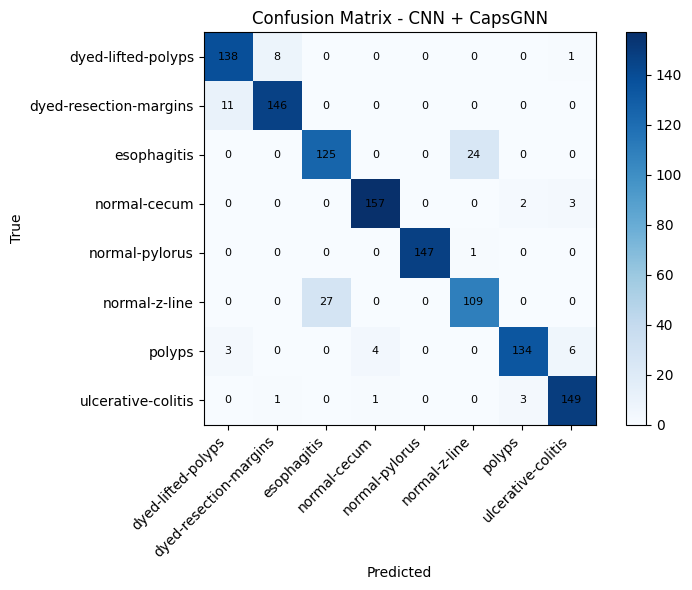

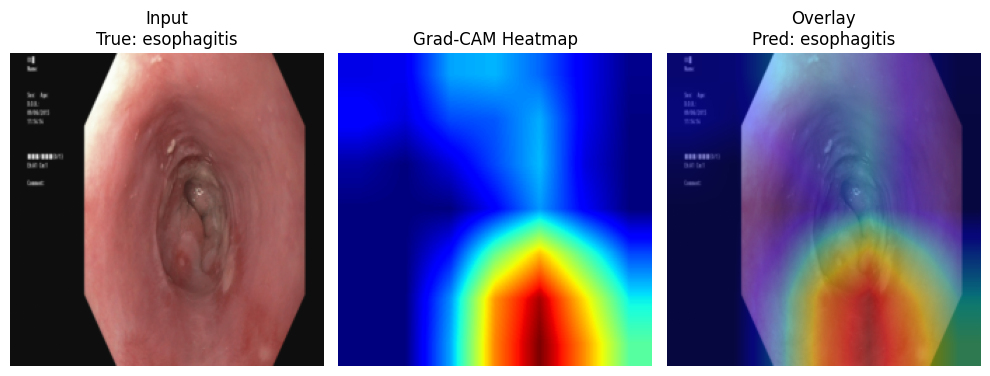

In [ ]:
# ---------------------------
# Test evaluation + confusion matrix + Grad-CAM
# ---------------------------
import os
import glob
import json
import zipfile
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

def evaluate_model(model, loader, criterion):
    model.eval()
    preds_all, targets_all = [], []
    running_loss = 0.0

    with torch.no_grad():
        for images, labels in tqdm(loader, leave=False):
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            logits = model(images)
            loss = criterion(logits, labels)

            running_loss += loss.item()
            preds_all.append(logits.argmax(dim=1).cpu().numpy())
            targets_all.append(labels.cpu().numpy())

    preds_all = np.concatenate(preds_all)
    targets_all = np.concatenate(targets_all)
    avg_loss = running_loss / max(len(loader), 1)
    acc = accuracy_score(targets_all, preds_all)
    return avg_loss, acc, targets_all, preds_all

def expected_ckpt_name(model_name):
    return f"best_{model_name.lower().replace(' ', '_').replace('+', 'plus')}.pth"

def maybe_restore_from_zip():
    checkpoint_dir = CHECKPOINT_DIR if 'CHECKPOINT_DIR' in globals() else os.path.join(os.getcwd(), 'checkpoints')
    os.makedirs(checkpoint_dir, exist_ok=True)
    backup_zip_path = os.path.join(os.getcwd(), 'checkpoints_backup.zip')

    has_local_pth = any(f.endswith('.pth') for f in os.listdir(checkpoint_dir)) if os.path.isdir(checkpoint_dir) else False
    if has_local_pth:
        return checkpoint_dir

    if os.path.exists(backup_zip_path):
        with zipfile.ZipFile(backup_zip_path, 'r') as zf:
            zf.extractall(checkpoint_dir)
        print(f"Restored checkpoints from backup zip: {backup_zip_path}")

    return checkpoint_dir

def find_checkpoint(filename):
    checkpoint_dir = maybe_restore_from_zip()
    search_dirs = [checkpoint_dir, os.getcwd(), '/kaggle/working', '/content', '/root', '/tmp']
    checked = []

    for base in search_dirs:
        if not os.path.isdir(base):
            continue
        checked.append(base)

        direct = os.path.join(base, filename)
        if os.path.exists(direct):
            return direct, checked

        matches = glob.glob(os.path.join(base, '**', filename), recursive=True)
        if matches:
            matches.sort(key=lambda p: os.path.getmtime(p), reverse=True)
            return matches[0], checked

    return None, checked

if 'model_factories' not in globals():
    raise RuntimeError('model_factories is not defined. Run Cell 5 (model definitions) first.')

if 'test_loader' not in globals() or 'class_names' not in globals() or 'test_dataset' not in globals():
    raise RuntimeError('Data loaders/classes are not defined. Run Cell 4 (dataset + dataloaders) first.')

if 'ablation_results' not in globals() or len(ablation_results) == 0:
    reconstructed = []
    all_checked = set()

    # First: try manifest from checkpoint dir
    checkpoint_dir = maybe_restore_from_zip()
    manifest_path = os.path.join(checkpoint_dir, 'ablation_results.json')
    if os.path.exists(manifest_path):
        with open(manifest_path, 'r', encoding='utf-8') as f:
            loaded = json.load(f)
        for item in loaded:
            if 'model_name' in item:
                expected_name = expected_ckpt_name(item['model_name'])
                ckpt_path, checked = find_checkpoint(expected_name)
                all_checked.update(checked)
                if ckpt_path is not None:
                    reconstructed.append({
                        'model_name': item['model_name'],
                        'save_path': ckpt_path,
                        'best_val_acc': item.get('best_val_acc', float('nan'))
                    })

    # Fallback: discover by expected names
    if len(reconstructed) == 0:
        for model_name in model_factories.keys():
            expected_name = expected_ckpt_name(model_name)
            ckpt_path, checked = find_checkpoint(expected_name)
            all_checked.update(checked)

            if ckpt_path is not None:
                reconstructed.append({
                    'model_name': model_name,
                    'save_path': ckpt_path,
                    'best_val_acc': float('nan')
                })
                print(f"Found checkpoint for {model_name}: {ckpt_path}")

    if len(reconstructed) == 0:
        checked_list = ', '.join(sorted(all_checked)) if len(all_checked) else '(no valid directories found)'
        raise RuntimeError(
            'ablation_results is missing and no checkpoints were found. '
            f'Searched under: {checked_list}. '
            'Run Cell 6 to train and create checkpoints_backup.zip, then download it for safety.'
        )

    ablation_results = reconstructed
    print(f"Recovered ablation_results from {len(ablation_results)} saved checkpoint(s).")

criterion = nn.CrossEntropyLoss()
test_results = []
for res in ablation_results:
    if not os.path.exists(res['save_path']):
        print(f"Skipping missing checkpoint: {res['save_path']}")
        continue

    name = res['model_name']
    model = model_factories[name]().to(device)
    model.load_state_dict(torch.load(res['save_path'], map_location=device))

    test_loss, test_acc, y_true, y_pred = evaluate_model(model, test_loader, criterion)
    test_results.append({
        'model_name': name,
        'test_loss': test_loss,
        'test_acc': test_acc,
        'y_true': y_true,
        'y_pred': y_pred,
    })

if len(test_results) == 0:
    raise RuntimeError('No evaluable checkpoints found. Run Cell 6 to produce best_*.pth files.')

print('\nAblation Summary (Test):')
for tr in test_results:
    print(f"{tr['model_name']:<18} | Test Loss: {tr['test_loss']:.4f} | Test Acc: {tr['test_acc'] * 100:.2f}%")

best_test = max(test_results, key=lambda x: x['test_acc'])
print(f"\nBest test model: {best_test['model_name']} ({best_test['test_acc'] * 100:.2f}%)")

print('\nClassification Report:')
print(classification_report(best_test['y_true'], best_test['y_pred'], target_names=class_names))

cm = confusion_matrix(best_test['y_true'], best_test['y_pred'])
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, cmap='Blues')
ax.set_title(f"Confusion Matrix - {best_test['model_name']}")
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.set_yticklabels(class_names)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black', fontsize=8)

fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        self.fwd_handle = target_layer.register_forward_hook(self._forward_hook)
        self.bwd_handle = target_layer.register_full_backward_hook(self._backward_hook)

    def _forward_hook(self, module, inputs, output):
        self.activations = output

    def _backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self, x, class_idx=None):
        self.model.eval()
        logits = self.model(x)

        if class_idx is None:
            class_idx = logits.argmax(dim=1).item()

        score = logits[:, class_idx]
        self.model.zero_grad(set_to_none=True)
        score.backward(retain_graph=True)

        grads = self.gradients
        acts = self.activations

        weights = grads.mean(dim=(2, 3), keepdim=True)
        cam = (weights * acts).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=(IMG_SIZE, IMG_SIZE), mode='bilinear', align_corners=False)

        cam = cam.squeeze().detach().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam, class_idx

    def close(self):
        self.fwd_handle.remove()
        self.bwd_handle.remove()

def denormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406], device=img_tensor.device).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=img_tensor.device).view(3, 1, 1)
    img = img_tensor * std + mean
    return img.clamp(0, 1)

best_model_name = best_test['model_name']
best_model = model_factories[best_model_name]().to(device)
best_model.load_state_dict(torch.load(next(r['save_path'] for r in ablation_results if r['model_name'] == best_model_name), map_location=device))

sample_img, sample_label = test_dataset[0]
input_tensor = sample_img.unsqueeze(0).to(device)

target_layer = best_model.backbone.features[-1]
grad_cam = GradCAM(best_model, target_layer)
cam, pred_idx = grad_cam.generate(input_tensor)
grad_cam.close()

img_np = denormalize(sample_img.to(device)).permute(1, 2, 0).detach().cpu().numpy()

plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.imshow(img_np)
plt.title(f"Input\nTrue: {class_names[sample_label]}")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cam, cmap='jet')
plt.title('Grad-CAM Heatmap')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img_np)
plt.imshow(cam, cmap='jet', alpha=0.45)
plt.title(f"Overlay\nPred: {class_names[pred_idx]}")
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Multiple-sample Grad-CAM check
indices = [0, 10, 25, 100, 250, 500, 750, 999]  # change these as needed

if 'best_model' not in globals():
    raise RuntimeError("Run Cell 7 first so best_model is available.")
if 'test_dataset' not in globals() or 'class_names' not in globals():
    raise RuntimeError("Run Cell 4 first so test_dataset/class_names are available.")

for idx in indices:
    if idx < 0 or idx >= len(test_dataset):
        print(f"Skipping idx {idx}: out of range")
        continue

    sample_img, sample_label = test_dataset[idx]
    input_tensor = sample_img.unsqueeze(0).to(device)

    grad_cam = GradCAM(best_model, best_model.backbone.features[-1])
    cam, pred_idx = grad_cam.generate(input_tensor)
    grad_cam.close()

    img_np = denormalize(sample_img.to(device)).permute(1, 2, 0).detach().cpu().numpy()
    is_correct = (pred_idx == sample_label)
    title_color = 'green' if is_correct else 'red'

    plt.figure(figsize=(8, 3.2))
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title(f"Idx {idx} | True: {class_names[sample_label]}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img_np)
    plt.imshow(cam, cmap='jet', alpha=0.45)
    plt.title(f"Pred: {class_names[pred_idx]}", color=title_color)
    plt.axis('off')

    plt.tight_layout()
    plt.show()